# Assignment5
## CS-5891-01 Special Topics Deep Learning
## Ronald Picard

In this notebook we will walk through the design, training, and testing of neural networks with multiple hidden layers. We will train networks utilizing L2 reguarlization and dropout. These nueral networks will be used for logistic regression, which is an archaic name for binary classification.

The binary classification will be performed on a simple 2-D dataset. This data will be randomly generated based on two interleaving half circles. The data points for one half circle are labeled 0 and the others are labeled 1. 

The goal of this this binary clasification will be first to classify each data point according to which half circle it belongs to. We will illustrated how well out networks do this by drawing the decision boundary. This decision boundary will also reveal overfitting. We will then investigate the imapact of reguarlization techniques on this overfitting.

To start we need to import some needed classes.

In [1]:
import os
import numpy as np
import struct
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as pyplot
import csv
import time
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
import sklearn.linear_model

from data_utils import plot_decision_boundary, load_moons

%matplotlib inline

# set global random seed
np.random.seed(10)

First we must generate and load our data set (both half moons).

(2, 200)
(1, 200)


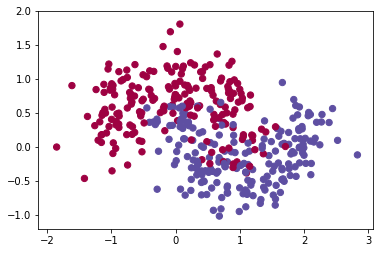

In [2]:
## path
train_X, train_Y = load_moons()
# Print accuracy on a test set generated using the same distribution
test_X, test_Y = load_moons()

print(train_X.shape)
print(train_Y.shape)

Next we predict labels using logistic regression classifier with scikit learn. 

In [3]:
# Class LogisticRegressionCV implements a logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV(cv=3);

# Returns 1-d array of shape (m,) 
_C = np.ravel(train_Y)

# Fit the model given the training data
clf.fit(train_X.T, _C.T)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

Now we predict the labels using the scikit learning logistic regression classifier.

In [4]:
# Print accuracy
# clf.predict returns labels for examples (of shape (m,n)) in x of shape (m,)
LR_predictions = clf.predict(train_X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(train_Y,LR_predictions) + np.dot(1-train_Y,1-LR_predictions))/float(train_Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Accuracy of logistic regression: 84 % (percentage of correctly labelled datapoints)


Finally, we plot the decision boundary.

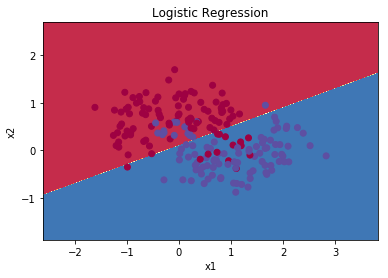

In [5]:
# Plot the decision boundary for logistic regression
plt.title("Logistic Regression")
plot_decision_boundary(lambda x: clf.predict(x), train_X, _C)

As we can see result is a linear seperation. However, for these two intersecting half circles we can see that this underfiting the data. This is because a good portion of the purple data is in the red section and vice version. It is clear that we need a non-linear model in order to not underfit the data. 

Now we generate two news half circles as a test data set.

In [6]:
# Print accuracy on a test set generated using the same distribution
#test_X, test_Y = load_moons()

# clf.predict returns labels for examples (of shape (m,n)) in x of shape (m,)
LR_predictions = clf.predict(test_X.T)
print ('Test accuracy of logistic regression: %d ' % float((np.dot(test_Y,LR_predictions) + np.dot(1-test_Y,1-LR_predictions))/float(test_Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

Test accuracy of logistic regression: 84 % (percentage of correctly labelled datapoints)


As we can see the accuracy of the test data is only 84%. This is similar to our test accuracy meaning it generalizes it's results well; even if it's results are bad. 

We will attempt to significantly increase the accuracy by training this data on a neural network with 2 hidden layers; the first with 20 units and the second with 10 units. No reguarlization techniques will be utilized at this point.

Now we will train our neural network with multiple hidden layers. 

Part 1 - Feed Forword:

For these neural networks we will use 2 hidden layers; the first will have 20 units (neurons), and the second will have 10 units. The first layer will have an input of a matrix (2 X number_of_samples) of vectorized data points of 2 X 1, and will output a matrix (# of units X # of samples). This matrix will be input into the next hidden layer, which output another matrix (# of units X # of images.) The output layer will take and input matrix that is the output matrix of the last hidden layer and will output a row vector of probabilities which we will convert into binary classifications of 0 or 1. (If P(x) >= 0.5 then we will convert it to a 1, otherwise we will convert to 0.) 

The model for the units of the hidden layers will be a vecorized linear model Z^[l] = W^[l]^T * A^[l-1] + B^[l], where W is a matrix of 2-20 units (# of units) X # of units or parameter weights, A is the input matrix of data points (2 X # of samples) or the output of one of the layers (1 X # of units), and B is a row vector of bias's. (Note: in this case, b will be scalar that applied in a broadcasing manner to save on memory.) The output of this model Z^[l] will be a matrix (2-20 units X # of images). Z^[1] will be subject to an activation function; which for this assignment will be relu (note: we will test tanh once for comparison). 

Hidden Layer Activation Function: relu activation function is A^[1]  = relu(Z) =  max(Z, 0).

The model of the output layer will be a vectorized linear model Z^[1] = W^[l] * A^[1] + b^[l] with a single unit. This linear model will be subjected to a sigmoid activation function.

The resultant row vector will then be used to calculate the cost function values in an elementwise manner. The cost function for this binary classification will be L(Y_Predicted, Y_Label) = -Y_Label^[l] * Log(A^[l]) - (1-Y_Predicted^[l]) * Log(1-A^[l]), where Y_Label is the True Label, Y_Predicted is the probability value predicted by the neural network, and A is the activation function value. The resultant cost row vector will be added up and divided by the number of elements in order to calculate the average cost.

Part 2 - Back Propogation:

The back propogation technique that we will use for training the neural network, will be gradient descent. This involves utilizing the gradient of the cost function to updated the model parameters in our layers. In order to calculate the gradient we will utilize the chain rule. The goal of back propogation is the adjust the parameter weights and bias's of our model to accurately perform binary classification. In general the chain rule can be used to find the gradient of the cost function (vecorzied rates of change) with respect to the model parameters. The following is the chain that we will utilize. 


Generalized Chain Rule for N layers: 

dL(A^[n], Y)/dW^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dW^[l];

dL(A^[n], Y)/dB^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dz^[l]/dB^[l];



Output Layer - Back Propogation:

The partial derivative of the cost function with respect to the output layer sigmoid activation function is found by the following:

dL(A^[n], Y)/dA^[n] = -Y/A^[n] + (1-A^[n])/(1-A^[n]).


Due to the chain rule, the derivative of the cost function with respect to the linear model Z^[n] is found by the following:

dL(A^[n], y)/dz = dL(A^[n], y)/dA^[n] * dA^[n]/dZ^[n].

The derivative of the sigmoid activation function is da/dz is found by the following:

dA^[n]/dZ^[n] = sigma(Z^[n]) * (1-sigma(Z^[n]))

Therefore, the derivative of the cost function with respect to the output of the linear model is found by the following:

dL(A^[n], Y)/dA^[n] * dA^[n]/dZ^[n]. = (-Y/A^[n] + (1-Y)/(1-A^[n])) * (sigma(Z^[n]) * (1-sigma(Z^[n]))) = A^[n]-Y. (For convienence we will say dZ^[n] = A^[n]-Y.)

Now we can extrapolate the chain rule to all the paramters of the linear model our output layer.

dL(A^[n], Y)/dW^[n] = dZ^[n] * dZ^[n]/dW^[n] = dZ^[n] * A^[n-1] = A^[n-1] * dZ^[n] (we will change our notation to dW^[n] = A^[n-1] * dZ^[n] for convienence)

dL(A^[n], Y)/dB^[n] = dZ^[n] * dZ^[n]/dB^[n] = dZ^[n] (we will change our notation to dW^[n] = dZ^[n] for convienence)



Hidden Layers - Back Propagation:

dL(A^[n], Y)/dZ^[l] = ∏(i = n to l) (dl(A^[i], Y)/dz^[i]) * dZ^[i]/dA^[i-1] * dA^[i-1]/dZ^[i-2] *....* dA^[l]/dZ^[l]

dL(A^[n], Y)/dZ^[l] = dZ^[l+1] * dZ^[l+1]/dA^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1]. The reason this is element-wise is because we are propgating from a single neuron to a layer with multiple neurons (we shall rename this dz^[l] = W^[l+1] * dz^[l+1] * (element-wise) dA^[1]/dZ^[1] for conveinience) 

dA^[1]/dZ^[1] depends on the activation function we are using in the hidden layer (in this case relu): The derivative of relu activation function is dA^[l]/dZ^[l] = if Z^[l] > 0 then 1 else 0.


dL(A^[n], Y)/dW^[l] = dZ^[l] * dZ^[l]/dW^[l] = dZ^[l] * X^T (we will change our notation to dW^[l] = dZ^[l] * A[l-1]^T for convienence)

dL(A^[n], Y)/dB^[l] = dZ^[l] * dZ^[l]/dB^[l] = dZ^[l] (we will change our notation to dB^[l] = dZ^[l] for convienence)


Find vector averages:

m = # number of images

dW^[l] = 1/m * (A^[l-1] * dZ^[l])

dB^[l] = 1/m * (dZ^[l])


Finally, we will update our the weights and bias's of the layers.


W^[l]:= W^[l] - alpha * dW^[l]

B^[l]:= B^[l] - alpha * dB^[l]


The first thing we have have to do is initialize our weights and bias's. There are multiple ways to initialize weights and bias's. Typically we will set our values based on either a uniform distribution between, or a normal distribution with a mean and some reasonable standard deviation. There is some flexibility in the initalization of the weights but in general they need to be small (not to small) and varied. The weights need to be different so that the gradients with respect to each other are different. In other words we don't aways want the relative rates of change to be 0. Additionally, we do not want to reach saturation on our output activation function where the gradients are 0 (vanishing gradiants). 

For this assignment many weight initializations were tested, but the best results were attained when using a uniform distribution between -.99 and .99. One potential reason that the weights for this assignment are higher than for previous assignments is because with this assignment we only have 200 samples. With such little data we likely need to larger initial gradients between the weights. We will set a random seed each time so that we form our rand values to be the same.

In [15]:
# initialize weights & bias
np.random.seed(10)
size = len(train_X[:,0])
print('Feature Size: ' + str(size))

lower_bound = -.99
upper_bound = .99

#mean = 0.015
#std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit

Feature Size: 2
Weights Shape: (20, 2)
Bias Shape: (20, 1)


Now we implement our gradient descent algorithm. 

We will also collect data on the accuracy of our network as a function of training iterations. To do this we will need to find the number of inaccuracate binary classifications (false positives & false negatives). This will be acommplished using our test data set. We will send our test data set through the network and compare the results with the true labels of the test data set. 

Main Loop Iteration: 10000
Cost: 0.2166964405080079
Main Loop Iteration: 20000
Cost: 0.2051823753580052
Main Loop Iteration: 30000
Cost: 0.19900076490220708
Main Loop Iteration: 40000
Cost: 0.19360354048700912
Main Loop Iteration: 50000
Cost: 0.1894969694709237
Main Loop Iteration: 60000
Cost: 0.1861512772273354
Main Loop Iteration: 70000
Cost: 0.183212623696625
Main Loop Iteration: 80000
Cost: 0.17901372551102426
Main Loop Iteration: 90000
Cost: 0.17656921539909504
Main Loop Iteration: 100000
Cost: 0.1742266721624227
Main Loop Iteration: 110000
Cost: 0.17211544369486212
Main Loop Iteration: 120000
Cost: 0.16950429561372563
Main Loop Iteration: 130000
Cost: 0.16694299030664206
Main Loop Iteration: 140000
Cost: 0.16443834991037265
Main Loop Iteration: 150000
Cost: 0.16250663618161007
Main Loop Iteration: 160000
Cost: 0.16085363775573056
Main Loop Iteration: 170000
Cost: 0.15928607275459247
Main Loop Iteration: 180000
Cost: 0.15802093544544613
Main Loop Iteration: 190000
Cost: 0.15690970

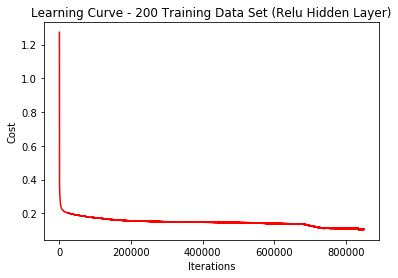

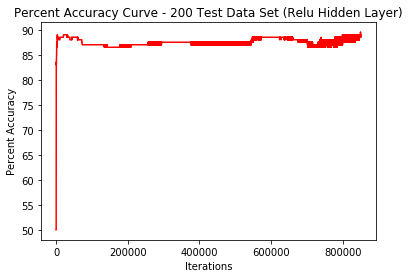

In [16]:
# gradient descent

detailed_logger = False
main_logger = True
main_logger_output_iterations = 10000
L2 = False
Dropout = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .5
number_of_iterations = 850000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = np.float64(train_X).copy()
Y = np.float64(np.ravel(train_Y)).copy()

X_test = np.float64(test_X).copy()
Y_test = np.float64(np.ravel(test_Y)).copy()

#m = size
m = 200

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-6
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*m), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/m, np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/m, W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/m, np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    
    
# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True and iteration % main_logger_output_iterations == 0):
        print('Main Loop Iteration: ' + str(iteration))
    
    if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
        print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
        break
    
    # forward propogation training data set
    A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X, [X], [], 0, [], keep_prob)
    L = loss(A_layers[len(A_layers) - 1], Y)
    if(L2 == True):
        C = cost_L2(L, W, epsilon) 
    else:
        C = cost(L) 
        
    if(iteration % main_logger_output_iterations == 0):
        print('Cost: ' + str(C))
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D)


    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As Illustrated after 850,000 iterations we have converged to a cost of approimately 0.1, but our testing accuracy is only 88.5 percent. This indicates that our network has overfit our training data so that it does not generalize well to our test data.

Now we will look at the decision boundary.

Training accuracy of logistic regression: 95 % (percentage of correctly labelled datapoints)


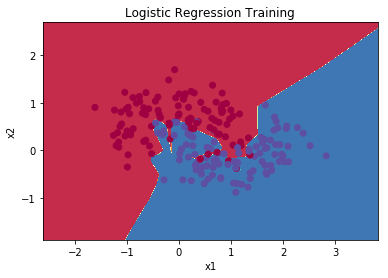

Test accuracy of logistic regression: 89 % (percentage of correctly labelled datapoints)


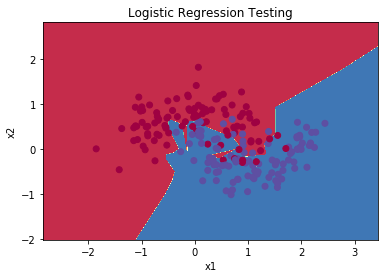

In [18]:
def predict_plot(P, X):
    pred = prediction(forward_propagation(P[0], P[1], np.transpose(X), 0))
    return pred

# forward propogation test data set
A_train = forward_propagation(W, B, X, 0)

# accuracy
_prediction_train = prediction(A_train)    
_accuracy_train = accuracy(_prediction_train, Y) 

print ('Training accuracy of logistic regression: %d ' % float(_accuracy_train) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Training")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X, Y)

# forward propogation test data set
A_test = forward_propagation(W, B, X_test, 0)

# accuracy
_prediction = prediction(A_test)    
_accuracy = accuracy(_prediction, Y_test) 

print ('Test accuracy of logistic regression: %d ' % float(_accuracy) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Testing")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X_test, Y_test)

As Illustrated, we our network has overfit the data. Though it performs well on the training set, it performs significantly less well on the testing set.

We can see from our plots that we have definatley overfit our training data. The boundary is not smooth, but rather jaged. This boundary may help increase the accuracy on the training data, but not on the test data. 

In order to help prevent this we will run the same network, however, we will add L2 penalization. This will be used in an attempt to prevent overfiting our training data. 

The only differences in our network will a new cost function and dW function.

The cost becomes:

C = epsilon/(2 * m), W^[i]^T * W^[i] + 1/m * sum(L), where epsilon is the hyper-parameter determining the weight of the L2 cost penalty. 

The dW function becomes:

dW = epsilon/m * W + 1/m * dZ * A^T

First, we reinitialize our weights.

In [23]:
# initialize weights & bias
np.random.seed(10)
size = len(train_X[:,0])
print('Feature Size: ' + str(size))

lower_bound = -.99
upper_bound = .99

#mean = 0.015
#std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit

Feature Size: 2
Weights Shape: (20, 2)
Bias Shape: (20, 1)


Now we re-run our gradient descent algorithm with L2 Penalization. We will choose a reasonable epsilon penalty weight of .85.

Main Loop Iteration: 10000
Cost: 0.34498623686264956
Main Loop Iteration: 20000
Cost: 0.31067705506755644
Main Loop Iteration: 30000
Cost: 0.2970519488259844
Main Loop Iteration: 40000
Cost: 0.2906012555913514
Main Loop Iteration: 50000
Cost: 0.28730002199254273
Main Loop Iteration: 60000
Cost: 0.28588524567233486
Main Loop Iteration: 70000
Cost: 0.2851716280779994
Main Loop Iteration: 80000
Cost: 0.2847694297192991
Main Loop Iteration: 90000
Cost: 0.28451206231629234
Main Loop Iteration: 100000
Cost: 0.2843380508476758
Main Loop Iteration: 110000
Cost: 0.2842034356472791
Main Loop Iteration: 120000
Cost: 0.2840933921880398
Main Loop Iteration: 130000
Cost: 0.284000635541277
Main Loop Iteration: 140000
Cost: 0.28391551184970043
Main Loop Iteration: 150000
Cost: 0.2838256008984101
Main Loop Iteration: 160000
Cost: 0.28372793254407885
Main Loop Iteration: 170000
Cost: 0.28363125182045035
Main Loop Iteration: 180000
Cost: 0.28323394175205674
Main Loop Iteration: 190000
Cost: 0.28286183461

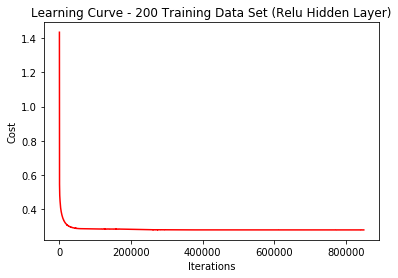

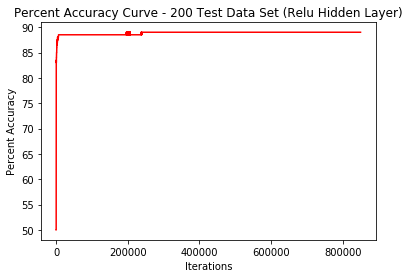

In [24]:
# gradient descent

detailed_logger = False
main_logger = True
main_logger_output_iterations = 10000
L2 = True
Dropout = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .85
keep_prob = .5
number_of_iterations = 850000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = np.float64(train_X).copy()
Y = np.float64(np.ravel(train_Y)).copy()

X_test = np.float64(test_X).copy()
Y_test = np.float64(np.ravel(test_Y)).copy()

#m = size
m = 200

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-6
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*m), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/m, np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/m, W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/m, np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    
    
# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True and iteration % main_logger_output_iterations == 0):
        print('Main Loop Iteration: ' + str(iteration))
    
    if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
        print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
        break
    
    # forward propogation training data set
    A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X, [X], [], 0, [], keep_prob)
    L = loss(A_layers[len(A_layers) - 1], Y)
    if(L2 == True):
        C = cost_L2(L, W, epsilon) 
    else:
        C = cost(L) 
        
    if(iteration % main_logger_output_iterations == 0):
        print('Cost: ' + str(C))
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D)


    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As we can see, after 850,000 iterations, the cost function converges to aproximately 0.27. This is slightly higher than without L2 penalization. This is expected because we have an additionally L2 penalty added to the cost. We also see a small increase in the accuracy to 89% of the test data over the previous network that did not include L2 penalization. This indicates that we have not overfit out training data.

We will not examine the decision boundary.

Training accuracy of logistic regression: 91 % (percentage of correctly labelled datapoints)


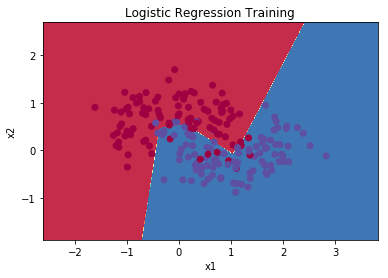

Test accuracy of logistic regression: 89 % (percentage of correctly labelled datapoints)


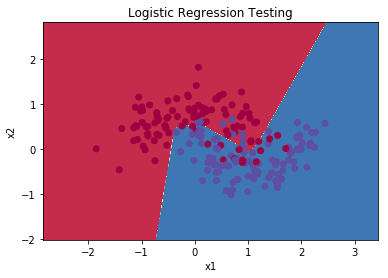

In [25]:
def predict_plot(P, X):
    pred = prediction(forward_propagation(P[0], P[1], np.transpose(X), 0))
    return pred

# forward propogation test data set
A_train = forward_propagation(W, B, X, 0)

# accuracy
_prediction_train = prediction(A_train)    
_accuracy_train = accuracy(_prediction_train, Y) 

print ('Training accuracy of logistic regression: %d ' % float(_accuracy_train) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Training")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X, Y)

# forward propogation test data set
A_test = forward_propagation(W, B, X_test, 0)

# accuracy
_prediction = prediction(A_test)    
_accuracy = accuracy(_prediction, Y_test) 

print ('Test accuracy of logistic regression: %d ' % float(_accuracy) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Testing")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X_test, Y_test)

As we can see our decision curve has smoothed out. This is primarliy because of the L2 penalization we put on the variance of the weights. This prevents any specific weights from becoming too important, and keeps all them relatively stable in orders of magnitude. We can see the accuracy of our training data decreased, but the accuracy of our test data has slightly improved. This indicates that our L2 penalization has help generalize our network.

Now we wish to explore the impact of adjusting L2 reguarlization hyper parameter. We will update it to 0.1 and look at the results.

In [ ]:
# initialize weights & bias
np.random.seed(10)
size = len(train_X[:,0])
print('Feature Size: ' + str(size))

lower_bound = -.99
upper_bound = .99

#mean = 0.015
#std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit

Now we re-run our gradient descent algorithm with a 0.1 L2 reguarlization hyper-parameter.

Main Loop Iteration: 10000
Cost: 0.2407950315174986
Main Loop Iteration: 20000
Cost: 0.23072662594920001
Main Loop Iteration: 30000
Cost: 0.2256844816431174
Main Loop Iteration: 40000
Cost: 0.22208008996732334
Main Loop Iteration: 50000
Cost: 0.2189736515340905
Main Loop Iteration: 60000
Cost: 0.21634808136846495
Main Loop Iteration: 70000
Cost: 0.21436287017103725
Main Loop Iteration: 80000
Cost: 0.21266944020812625
Main Loop Iteration: 90000
Cost: 0.2111872360718793
Main Loop Iteration: 100000
Cost: 0.20973440885564926
Main Loop Iteration: 110000
Cost: 0.2083522202168148
Main Loop Iteration: 120000
Cost: 0.20710447212662847
Main Loop Iteration: 130000
Cost: 0.20595871413451652
Main Loop Iteration: 140000
Cost: 0.2045914480926378
Main Loop Iteration: 150000
Cost: 0.2035995123294636
Main Loop Iteration: 160000
Cost: 0.20279295037560865
Main Loop Iteration: 170000
Cost: 0.20204626660974595
Main Loop Iteration: 180000
Cost: 0.20138886404043466
Main Loop Iteration: 190000
Cost: 0.20084645

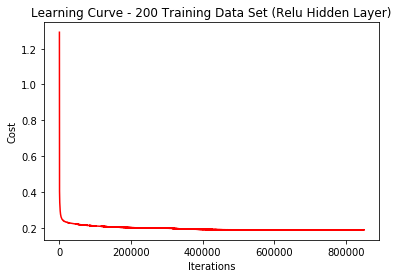

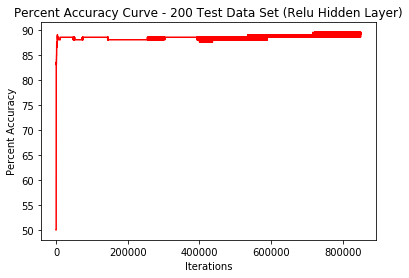

In [26]:
# gradient descent

detailed_logger = False
main_logger = True
main_logger_output_iterations = 10000
L2 = True
Dropout = False
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .10
keep_prob = .5
number_of_iterations = 850000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = np.float64(train_X).copy()
Y = np.float64(np.ravel(train_Y)).copy()

X_test = np.float64(test_X).copy()
Y_test = np.float64(np.ravel(test_Y)).copy()

#m = size
m = 200

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-6
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*m), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/m, np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/m, W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/m, np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    
    
# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True and iteration % main_logger_output_iterations == 0):
        print('Main Loop Iteration: ' + str(iteration))
    
    if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
        print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
        break
    
    # forward propogation training data set
    A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X, [X], [], 0, [], keep_prob)
    L = loss(A_layers[len(A_layers) - 1], Y)
    if(L2 == True):
        C = cost_L2(L, W, epsilon) 
    else:
        C = cost(L) 
        
    if(iteration % main_logger_output_iterations == 0):
        print('Cost: ' + str(C))
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D)


    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

As we can see the cost is much lower with a lower reguarlization hyper-parameter. This could also indicate that we have slighly ovefit the data more than when we penalzied the weight variances more using a higher hyper-paramter.

Training accuracy of logistic regression: 92 % (percentage of correctly labelled datapoints)


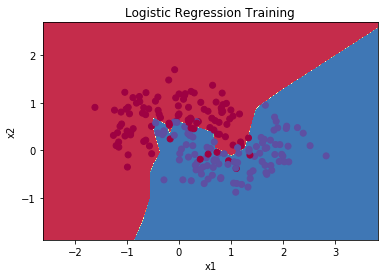

Test accuracy of logistic regression: 89 % (percentage of correctly labelled datapoints)


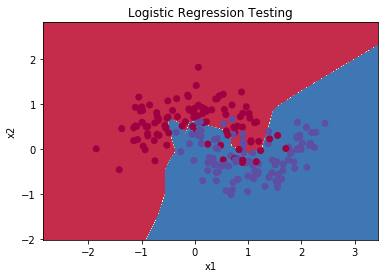

In [27]:
def predict_plot(P, X):
    pred = prediction(forward_propagation(P[0], P[1], np.transpose(X), 0))
    return pred

# forward propogation test data set
A_train = forward_propagation(W, B, X, 0)

# accuracy
_prediction_train = prediction(A_train)    
_accuracy_train = accuracy(_prediction_train, Y) 

print ('Training accuracy of logistic regression: %d ' % float(_accuracy_train) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Training")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X, Y)

# forward propogation test data set
A_test = forward_propagation(W, B, X_test, 0)

# accuracy
_prediction = prediction(A_test)    
_accuracy = accuracy(_prediction, Y_test) 

print ('Test accuracy of logistic regression: %d ' % float(_accuracy) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Testing")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X_test, Y_test)

As we can see we did slighly overfit the training data more than when we had a higher reguarlization L2 hyper parameter. This lines up with what we would intuitively expect. Since we did not penalize the variance of the weights as much as previously, some of them recieve more critical changes than others resulting in some overfiting of the training data.

Now now we will look at drop out as a technique for reguarlization. Dropout is where we turn off, and only keep on certain neurons in each layer, each iteration, based on a keep-probability hyper-parameter. We will start with a keep-probabiliy of .85 and see what results we achieve.   

First we reinitialize our weights and bias's.

In [28]:
# initialize weights & bias
np.random.seed(10)
size = len(train_X[:,0])
print('Feature Size: ' + str(size))

lower_bound = -.99
upper_bound = .99

#mean = 0.015
#std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit

Feature Size: 2
Weights Shape: (20, 2)
Bias Shape: (20, 1)


Now we run gradient descent with dropout.

Main Loop Iteration: 10000
Cost: 1.3782215993025186
Main Loop Iteration: 20000
Cost: 1.4960904491843472
Main Loop Iteration: 30000
Cost: 1.407189595249288
Main Loop Iteration: 40000
Cost: 1.6669136124280886
Main Loop Iteration: 50000
Cost: 0.975890596161313
Main Loop Iteration: 60000
Cost: 1.2924007541561704
Main Loop Iteration: 70000
Cost: 1.424587154324683
Main Loop Iteration: 80000
Cost: 1.2569386513678142
Main Loop Iteration: 90000
Cost: 1.0945716769486817
Main Loop Iteration: 100000
Cost: 1.4958703256817794
Main Loop Iteration: 110000
Cost: 1.0025054288411999
Main Loop Iteration: 120000
Cost: 1.2498264813152238
Main Loop Iteration: 130000
Cost: 1.5512016137794342
Main Loop Iteration: 140000
Cost: 1.4851820361744437
Main Loop Iteration: 150000
Cost: 1.0826413354122641
Main Loop Iteration: 160000
Cost: 1.1104802810609196
Main Loop Iteration: 170000
Cost: 1.265841341186896
Main Loop Iteration: 180000
Cost: 1.3992414223761995
Main Loop Iteration: 190000
Cost: 1.098810208061231
Main Lo

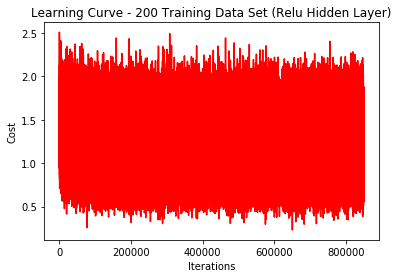

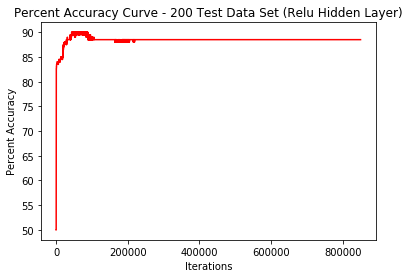

In [29]:
# gradient descent

detailed_logger = False
main_logger = True
main_logger_output_iterations = 10000
L2 = False
Dropout = True
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .10
keep_prob = .85
number_of_iterations = 850000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = np.float64(train_X).copy()
Y = np.float64(np.ravel(train_Y)).copy()

X_test = np.float64(test_X).copy()
Y_test = np.float64(np.ravel(test_Y)).copy()

#m = size
m = 200

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-6
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*m), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/m, np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/m, W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/m, np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    
    
# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True and iteration % main_logger_output_iterations == 0):
        print('Main Loop Iteration: ' + str(iteration))
    
    if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
        print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
        break
    
    # forward propogation training data set
    A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X, [X], [], 0, [], keep_prob)
    L = loss(A_layers[len(A_layers) - 1], Y)
    if(L2 == True):
        C = cost_L2(L, W, epsilon) 
    else:
        C = cost(L) 
        
    if(iteration % main_logger_output_iterations == 0):
        print('Cost: ' + str(C))
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D)


    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

After 850,000 iterations our cost converges to around 1.29, and our testing accuracy is about 88.5%. We can note from the learning curve that because during every iteration only a subset of the neurons are being trainied, the learning curve jumps around rapidly. Usually, there is still a downward trend. In this case we convege rapidly so this trend can be hard to see on the learning curve. However, the test accuracy curve provides some good insight into how the network is improving. 

Now let's look at the decision boundary.

Training accuracy of logistic regression: 93 % (percentage of correctly labelled datapoints)


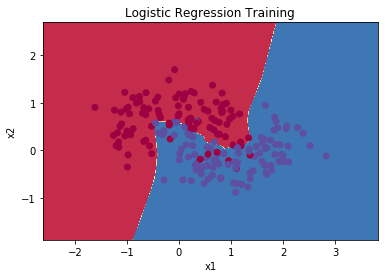

Test accuracy of logistic regression: 88 % (percentage of correctly labelled datapoints)


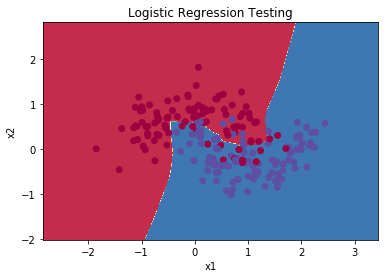

In [30]:
def predict_plot(P, X):
    pred = prediction(forward_propagation(P[0], P[1], np.transpose(X), 0))
    return pred

# forward propogation test data set
A_train = forward_propagation(W, B, X, 0)

# accuracy
_prediction_train = prediction(A_train)    
_accuracy_train = accuracy(_prediction_train, Y) 

print ('Training accuracy of logistic regression: %d ' % float(_accuracy_train) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Training")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X, Y)

# forward propogation test data set
A_test = forward_propagation(W, B, X_test, 0)

# accuracy
_prediction = prediction(A_test)    
_accuracy = accuracy(_prediction, Y_test) 

print ('Test accuracy of logistic regression: %d ' % float(_accuracy) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Testing")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X_test, Y_test)

As shown, dropout reguarlization help to smooth the curve and prevent overfitting compared to the network that that did not include any regularization techniques. This helps the boundary generalize to the test data. 

Now we wish to invetigate the change in the keep-probability hyper-parameter for dropout. We will increas this to .95 and analyze the results.

First we reinitialize our weights and bias's.

In [32]:
# initialize weights & bias
np.random.seed(10)
size = len(train_X[:,0])
print('Feature Size: ' + str(size))

lower_bound = -.99
upper_bound = .99

#mean = 0.015
#std = 0.005


# hyper-parameters: hidden layers
hidden_layers = 2
units_array = [20, 10]
Weights = []
Bias = []
for i in range(0, hidden_layers):
    if(i == 0):
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], size]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    else:
        _W = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], units_array[i-1]]))
        _B = np.float64(np.random.uniform(lower_bound, upper_bound, [units_array[i], 1]))
        Weights.append(_W)
        Bias.append(_B)
    
# output layer
_W = np.float64(np.random.uniform(lower_bound, upper_bound, [1, units_array[i]]))
_b = np.float64(np.random.uniform(lower_bound, upper_bound)) # b will be added in a broadcasting manner

Weights.append(_W)
Bias.append(_b)

Weights = np.array(Weights)
Bias = np.array(Bias)

for index in range(0, len(Weights) - 1):
    Weights[index] = np.where(Weights[index] != 0, Weights[index], np.random.uniform(lower_bound, upper_bound))

#print(train_X.shape)
#print(np.ravel(train_Y).shape)

print('Weights Shape: ' + str(Weights[0].shape)) # matrix with a size of # of units X 784
print('Bias Shape: ' + str(Bias[0].shape)) # vector with a size of the # of unit

Feature Size: 2
Weights Shape: (20, 2)
Bias Shape: (20, 1)


Now we re-run gradient descent with our updated hyper-parameter.

Main Loop Iteration: 10000
Cost: 0.5359519845787896
Main Loop Iteration: 20000
Cost: 0.7733333701165739
Main Loop Iteration: 30000
Cost: 0.48369309336163846
Main Loop Iteration: 40000
Cost: 0.5357720696190724
Main Loop Iteration: 50000
Cost: 0.3728185101009353
Main Loop Iteration: 60000
Cost: 0.3905542551773027
Main Loop Iteration: 70000
Cost: 0.5907365656564663
Main Loop Iteration: 80000
Cost: 0.7206534547399903
Main Loop Iteration: 90000
Cost: 0.4056943138381125
Main Loop Iteration: 100000
Cost: 0.586695608450397
Main Loop Iteration: 110000
Cost: 0.600281492731963
Main Loop Iteration: 120000
Cost: 0.5420357619832692
Main Loop Iteration: 130000
Cost: 0.683625600370674
Main Loop Iteration: 140000
Cost: 0.5333309264745878
Main Loop Iteration: 150000
Cost: 0.38708464002314447
Main Loop Iteration: 160000
Cost: 0.3054834924868257
Main Loop Iteration: 170000
Cost: 0.3753207207124224
Main Loop Iteration: 180000
Cost: 0.5208020675461629
Main Loop Iteration: 190000
Cost: 0.5091682176735521
Mai

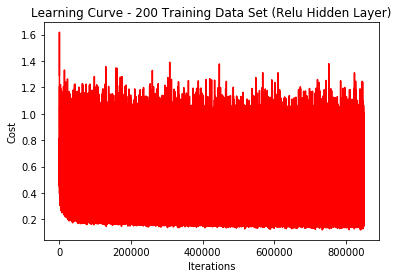

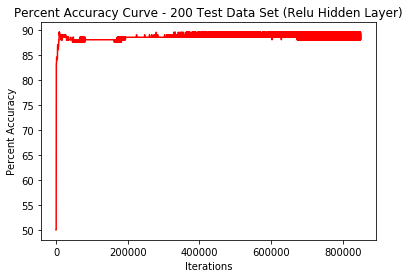

In [33]:
# gradient descent

detailed_logger = False
main_logger = True
main_logger_output_iterations = 10000
L2 = False
Dropout = True
hidden_layer_relu = True
hidden_layer_tanh = False
hidden_layer_sigmoid = False

# hyber-parameters
alpha = .01;
epsilon = .10
keep_prob = .95
number_of_iterations = 850000

# copy initalization
W = Weights.copy()
B = Bias.copy()

# data arrays
cost_array = []
accuracy_array = []
interation_array = []

# rename
X = np.float64(train_X).copy()
Y = np.float64(np.ravel(train_Y)).copy()

X_test = np.float64(test_X).copy()
Y_test = np.float64(np.ravel(test_Y)).copy()

#m = size
m = 200

def model(W, B, A):
    return np.dot(W, A) + B

def activation_relu(Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    return np.where(Z > 0, Z, 0)

def activation_tanh(Z):
    return np.tanh(Z)

def activation_sigmoid(Z):
     return 1/(1 + np.exp(-Z))

def loss(A, Y):
    epsilon = 1e-6
    return np.where((Y == 1), np.multiply(-Y, np.log(A + epsilon)), -np.multiply((1 - Y), np.log(1 - A + epsilon)))
    #return np.multiply(-Y, np.log(A)) - np.multiply((1 - Y), np.log(1 - A)) 
    
def cost(L):
    return np.multiply(1/len(L[0]), np.sum(L))

def cost_L2(L, W, epsilon):
    L2 = np.multiply(epsilon/(2*m), np.multiply(W[len(W)-3], W[len(W)-3]).sum() + np.multiply(W[len(W)-2], W[len(W)-2]).sum() + np.multiply(W[len(W)-1], W[len(W)-1]).sum())
    J = cost(L)
    return L2 + J

def prediction(A):
    return np.where(A >= 0.5, 1, 0)
    
def accuracy(prediction, Y):
    return 100 - np.multiply(100/len(Y), np.sum(np.absolute(Y - prediction)))  
    
def forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
        A_layers, Z_layers, D = forward_propagation_return_layers(W, B, A, A_layers, Z_layers, layer, D, keep_prob)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        Z_layers.append(Z)
        A = activation_sigmoid(Z)
        if(Dropout == True):
            _D = np.float64(np.where(np.random.uniform(0, 1, [len(W[layer][:]), m]) < keep_prob, 1, 0))
            D.append(_D)
            A = np.multiply(A, _D)
        A_layers.append(A)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Training Data: ' + str(layer))
            print('Forward Propagation Training Data Complete')
    return A_layers, Z_layers, D

def forward_propagation(W, B, A, layer):
    if(layer < len(W) - 1):
        Z = model(W[layer], B[layer], A)
        if(hidden_layer_relu == True):
            A = activation_relu(Z)
        elif(hidden_layer_tanh == True):
            A = activation_tanh(Z)
        elif(hidden_layer_sigmoid == True): 
            A = activation_sigmoid(Z)
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
        A = forward_propagation(W, B, A, layer)
    elif(layer == len(W) - 1):
        Z = model(W[layer], B[layer], A)
        A = activation_sigmoid(Z)  
        layer = layer + 1
        if(detailed_logger == True):
            print('Forward Layer Testing Data: ' + str(layer))
            print('Forward Propagation Testing Data Complete')
    return A

def dZ(dZ, W, Z):
    Z = np.where(~np.isnan(Z), Z, 0)
    W = np.where(~np.isnan(W), W, 0)
    dZ = np.where(~np.isnan(dZ), dZ, 0)
    Z = np.where(~np.isinf(Z), Z, 0)
    W = np.where(~np.isinf(W), W, 0)
    dZ = np.where(~np.isinf(dZ), dZ, 0)
    if(hidden_layer_relu == True):
        return np.multiply(np.dot(np.transpose(W), dZ), np.where(Z > 0, 1, 0))
    elif(hidden_layer_tanh == True):
        A = activation_tanh(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), 1- np.multiply(A, A))
    elif(hidden_layer_sigmoid == True): 
        A = activation_sigmoid(Z)
        return np.multiply(np.dot(np.transpose(W), dZ), np.multiply(A, (1-A)))

def dW(dZ, A):
    return np.multiply(1/m, np.dot(dZ, np.transpose(A)))

def dW_L2(dZ, A, W, epsilon):
    return np.multiply(epsilon/m, W) + dW(dZ, A)

def dB(dZ):
    return np.multiply(1/m, np.sum(dZ))

def backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D):
    if(layer >= 0):
        if(layer == len(W) - 1):
            _dZ = A_layers[layer+1] - Y
        elif(layer >= 0):
            _dZ = dZ(_dZ, W[layer+1], Z_layers[layer])
        if(Dropout == True):
            _dZ = np.multiply(_dZ, D[layer])
        if(L2 == True):
            _dW = dW_L2(_dZ, A_layers[layer], W[layer], epsilon)
        else:
            _dW = dW(_dZ, A_layers[layer])
        _dB = dB(_dZ)
        W[layer] = W[layer] - np.multiply(alpha, _dW)
        B[layer] = B[layer] - np.multiply(alpha, _dB)
        if(detailed_logger == True):
            print('Backward Layer: ' + str(layer))
        layer = layer - 1
        W, B = backward_propagation(W, B, A_layers, Z_layers, _dZ, alpha, epsilon, layer, D)
        if(detailed_logger == True):
            print('Backward Propagation Complete')
    return W, B
    
    
# main loop
for iteration in range(1, number_of_iterations + 1):
    if(main_logger == True and iteration % main_logger_output_iterations == 0):
        print('Main Loop Iteration: ' + str(iteration))
    
    if(hidden_layer_relu + hidden_layer_tanh + hidden_layer_sigmoid != 1):
        print("ERROR! Please Select Only 1 Hidden Layer Activation Function")
        break
    
    # forward propogation training data set
    A_layers, Z_layers, D = forward_propagation_return_layers(W, B, X, [X], [], 0, [], keep_prob)
    L = loss(A_layers[len(A_layers) - 1], Y)
    if(L2 == True):
        C = cost_L2(L, W, epsilon) 
    else:
        C = cost(L) 
        
    if(iteration % main_logger_output_iterations == 0):
        print('Cost: ' + str(C))
    
    # forward propogation test data set
    A_test = forward_propagation(W, B, X_test, 0)
    
    # accuracy
    _prediction = prediction(A_test)    
    _accuracy = accuracy(_prediction, Y_test)  
    
    # storage for plotting
    cost_array.append(C)
    accuracy_array.append(_accuracy)
    interation_array.append(iteration)
    
    # backpropogation
    W, B = backward_propagation(W, B, A_layers, Z_layers, 0, alpha, epsilon, len(W) - 1, D)


    
print('')
print('Results:')
print('')
    
print('')
print('Cost: ' + str(C))    
print('Accuracy: ' + str(_accuracy))    
print('')
print('')


pyplot.figure()
pyplot.plot(interation_array, cost_array, 'red')
pyplot.title('Learning Curve - ' + str(len(X[0])) + ' Training Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Cost')
pyplot.show()

# plot percent accuracy curve
pyplot.figure()
pyplot.plot(interation_array, accuracy_array, 'red')
pyplot.title('Percent Accuracy Curve - ' + str(len(X_test[0])) + ' Test Data Set (Relu Hidden Layer)')
pyplot.xlabel('Iterations')
pyplot.ylabel('Percent Accuracy')
pyplot.show()

We have achieved a cost of approximately 0.7 after 850,000 iterations. 

Some interesting results can be see by analyzing the boundary curve.

Training accuracy of logistic regression: 93 % (percentage of correctly labelled datapoints)


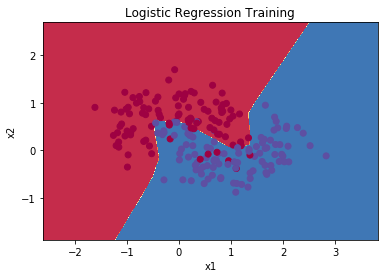

Test accuracy of logistic regression: 89 % (percentage of correctly labelled datapoints)


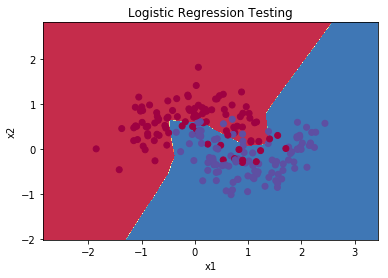

In [34]:
def predict_plot(P, X):
    pred = prediction(forward_propagation(P[0], P[1], np.transpose(X), 0))
    return pred

# forward propogation test data set
A_train = forward_propagation(W, B, X, 0)

# accuracy
_prediction_train = prediction(A_train)    
_accuracy_train = accuracy(_prediction_train, Y) 

print ('Training accuracy of logistic regression: %d ' % float(_accuracy_train) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Training")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X, Y)

# forward propogation test data set
A_test = forward_propagation(W, B, X_test, 0)

# accuracy
_prediction = prediction(A_test)    
_accuracy = accuracy(_prediction, Y_test) 

print ('Test accuracy of logistic regression: %d ' % float(_accuracy) +
       '% ' + "(percentage of correctly labelled datapoints)")

plt.title("Logistic Regression Testing")
plot_decision_boundary(lambda x: predict_plot([W, B], x), X_test, Y_test)

We note that this curve is slighly smoother than the case when the keep-probability hyper paramter was .85. This may be because by keeping 95% of the neurons in each layer during each iteration and only disabling 5% of the nuerons allows us to only disable the problem neurons, and train most of the neurons during every iteration. If there are only a few problem neurons that a high keep probability may be helping to smooth the curve and prevent overfiting. As noted, we still achieve 93% training accuracy on the training data, but we also recieve 89% percent testing accuracy. This indicates good generalization while still having a descent training accuracy. 

We have seen visual examples of how regularization techniques such as L2 penalization and dropout can help to generalize a network to work on unseen data and prevent overfitting the training data. We have also see the effects of adjusting the hyper-parameters of regularization techniques, and how they can help or harm the effectiveness of the regularization techniques.

In [ ]:
This concludes the assignment.